In [ ]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import theano

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import glob
import json
from scipy.stats import spearmanr
from tqdm import tqdm
from scipy.stats import percentileofscore, zscore
import pickle
import tables

os.chdir('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

## GP Latent Model

In [ ]:
## Quick change at stim delivery
dt = 0.001
x = np.arange(-0.5, 2, step = dt)
y = np.exp(-x*1)*1000
y[x<=0] = 0

# y = y[x>0]
# x = x[x>0]

spikes = np.random.uniform(size = len(y)) < y*dt
bin_width = 50
binned_counts = spikes.reshape((-1, bin_width)).sum(axis=-1)
binned_x = x.reshape((-1, bin_width)).mean(axis=-1)
fig,ax = plt.subplots(3,1, figsize=(7,10), sharex=True)
ax[0].plot(x,y)
ax[0].set_title('True Rate')
ax[1].plot(x,spikes)
ax[1].set_title('Spike Train')
ax[2].plot(binned_x, binned_counts)
ax[2].set_title('Binned Spikes')

In [ ]:
# binned_x = np.arange(len(data_vec))
# X=binned_x.copy()[:,None]
# binned_counts = data_vec + 1
# plt.plot(binned_x, binned_counts)

In [5]:
#https://docs.pymc.io/en/v3/pymc-examples/examples/gaussian_processes/GP-Latent.html
#https://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/GP-introduction.html
##http://evelinag.com/Ariadne/covarianceFunctions.html

with pm.Model() as model:
    
    ℓ = pm.Gamma("ℓ", alpha=1, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    # Specify the covariance function.
    #http://evelinag.com/Ariadne/covarianceFunctions.html
    cov = (η ** 2) * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=binned_x[:, None])
   
    lambda_ = pm.Deterministic('lambda_', tt.exp(f))
    rate = pm.Poisson("rate", lambda_, observed=binned_counts)
    
    trace = pm.sample(1000, chains=1, cores=1, return_inferencedata=True)
#     inference = pm.ADVI('full-rank')
#     approx = pm.fit(n=160000, method=inference)
#     trace = approx.sample(draws=2000)

Finished [100%]: Average Loss = 252.22


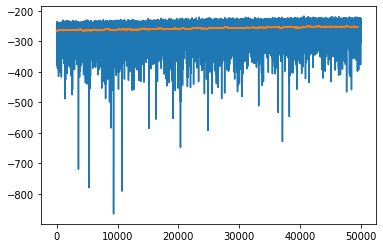

In [26]:
hist = -approx.hist[-50000:]
plt.plot(hist)
box_kern = np.ones(500)/500
plt.plot(np.convolve(hist,box_kern, mode='valid'))

In [6]:
# pm.model_to_graphviz(model)

In [7]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[lambda_], samples=50)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


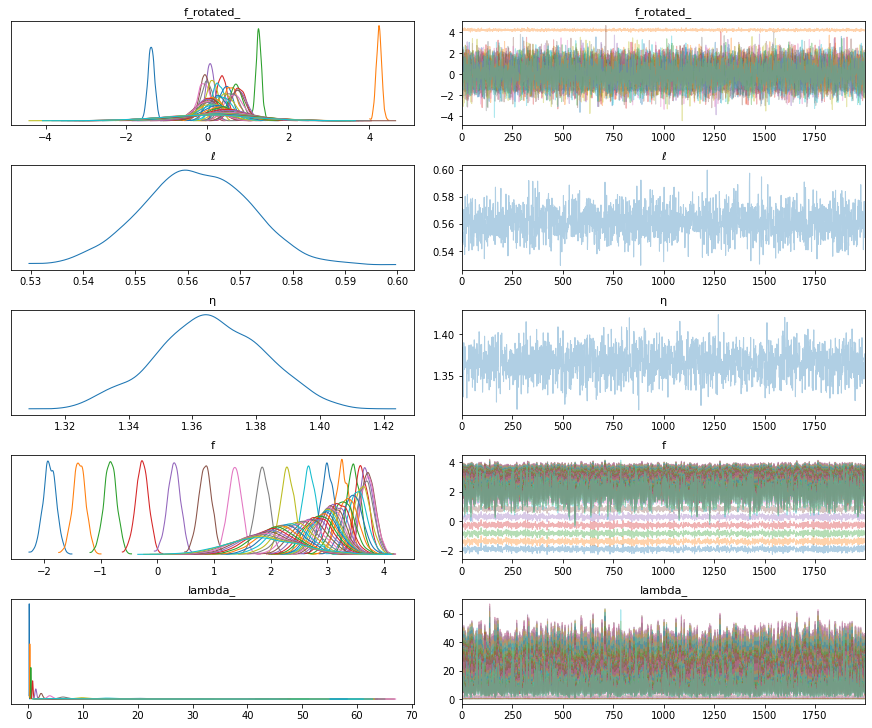

In [17]:
with model:
    pm.traceplot(trace);

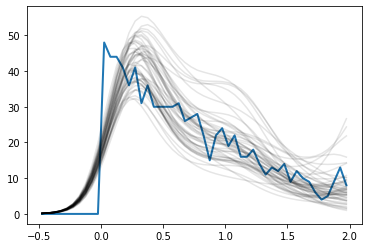

In [15]:
#plt.plot(binned_x, zscore(pred_samples['lambda_'].mean(axis=0),axis=-1), linewidth = 2)
plt.plot(binned_x, binned_counts, linewidth = 2);
plt.plot(binned_x, pred_samples['lambda_'].T, alpha = 0.1, color = 'k');